In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
project_path = '/content/drive/MyDrive/Montpellier/IMAGINE/S3/'

In [27]:
# pip install kagglehub

In [28]:
# pip install tensorflow

In [29]:
# pip install opencv-python

In [30]:
import kagglehub
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

Using Colab cache for faster access to the 'lfw-dataset' dataset.


In [31]:
import cv2
import os

In [32]:
# Load face detection classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [33]:
# This takes like 8 minutes

latent_dim = 128
image_size = 64
images = []

# Preprocess images
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".jpg"):
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)

            # Handle case where image could not be loaded
            if img is None:
                print(f"Warning: Could not load image {img_path}. Skipping.")
                continue

            # Convert to grey for face detection
            grey_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Call classifier on image to detect faces of any size
            face = face_classifier.detectMultiScale(
                grey_img, scaleFactor=1.1 , minNeighbors=5 , minSize=(40,40)
            )

            # Process and append images only if faces are detected
            if len(face) > 0:
                # Iterate through all detected faces (or pick the first one)
                for (x, y, w, h) in face:
                    x_max = x+w
                    y_max = y+h
                    # Ensure crop coordinates are within image bounds
                    x = max(0, x)
                    y = max(0, y)
                    x_max = min(img.shape[1], x_max)
                    y_max = min(img.shape[0], y_max)

                    if w > 0 and h > 0: # Ensure valid crop dimensions
                        im_cropped = img[y:y_max , x:x_max]

                        # Ensure im_cropped is not empty after cropping
                        if im_cropped.size == 0:
                            print(f"Warning: Empty crop for {img_path}. Skipping.")
                            continue

                        im_cropped = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2RGB)
                        im_cropped = cv2.resize(im_cropped, (image_size, image_size))
                        im_cropped = im_cropped.astype("float32") / 255.0
                        images.append(im_cropped)



In [34]:
from sklearn.model_selection import train_test_split
import numpy as np

images = np.array(images)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

print("Training shape:", x_train.shape)
print("Test shape:", x_test.shape)

Training shape: (11402, 64, 64, 3)
Test shape: (2851, 64, 64, 3)


In [35]:
from tensorflow import keras

# Create encoder
encoder = keras.models.Sequential([
    keras.layers.Input((64, 64, 3)),
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'), # I think that if we change the image size we have to change this value
    keras.layers.Dense(latent_dim * 2)
], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,256,448 (8.61 MB)

 Trainable params: 2,256,448 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Create decoder
decoder = keras.models.Sequential([
    keras.layers.Input((latent_dim,)),
    keras.layers.Dense(8 * 8 * 128, activation='relu'),
    keras.layers.Reshape((8, 8, 128)),
    keras.layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')
], name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,297,475 (4.95 MB)

 Trainable params: 1,297,475 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
import tensorflow as tf

# VAE creation
def sample_latent(z):
    z_mean, z_log_var = tf.split(z, num_or_size_splits=2, axis=1)
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
    return z, z_mean, z_log_var

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Forward pass para predicción / validation
        z_all = self.encoder(inputs)
        z, _, _ = sample_latent(z_all)
        reconstruction = self.decoder(z)
        return reconstruction


def vae_loss(y_true, y_pred):
    # Reconstrucción
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))

    # KL divergence
    z_all = vae.encoder(y_true)
    z_mean, z_log_var = tf.split(z_all, num_or_size_splits=2, axis=1)
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    )

    return reconstruction_loss + kl_loss

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss=vae_loss)

In [38]:
# Train the vae
epochs = 5
batch_size = 128
vae.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - loss: 0.0972 - val_loss: 0.0402
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 0.0392 - val_loss: 0.0391
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 0.0387 - val_loss: 0.0383
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - loss: 0.0378 - val_loss: 0.0381
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - loss: 0.0383 - val_loss: 0.0381


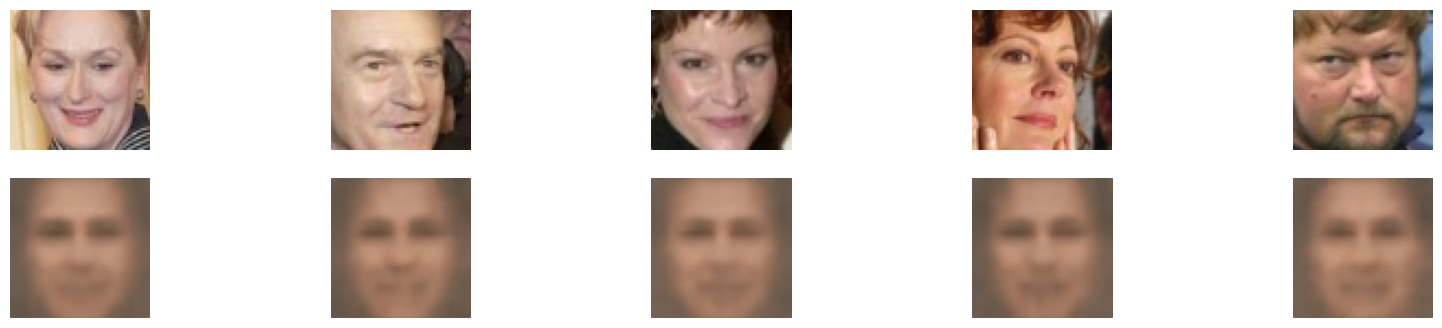

In [41]:
# Compare original and reconstructed images
import matplotlib.pyplot as plt
import numpy as np

n = 5
z_all = vae.encoder(x_test[:n])
z, _, _ = sample_latent(z_all)
decoded_imgs = vae.decoder(z)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")
plt.show()